# Classify Emails beyond spams - using K-Means Clustering

### This notebook shows the implementation of K-Means clustering WSD i.e. Word Sense Disambiguation. The synonyms and hypernyms have been included here. Level 3

### Final Project - Riti Chakraborty¶

In [1]:
#Riti Chakraborty

#importing the required libraries
import scipy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
#library for tf-idf vector
from sklearn.feature_extraction.text import TfidfVectorizer


import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import CountVectorizer
import numpy
from numpy import nan

#for flattening lists
from itertools import chain

#To handle warning
import warnings
warnings.filterwarnings('ignore')

#For implementing Natural Language Processing approaches.
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

#For using Regular expression
import re

#For Handling Strings
import string
#For plotting data
import matplotlib.pyplot as plt


#For implementing word sense disambiguation
from nltk.corpus import wordnet as wn
from wordsegment import load, segment

#Important to call load()
load()

#Importing Libraries required for arithmatic operations
from operator import mul 
from operator import add

#For LDA Implementation # Importing Gensim
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
from gensim import corpora

#For evaluation Topic models formed
from gensim.models import CoherenceModel

#For visualising LDA Output
import pyLDAvis
import pyLDAvis.gensim 

In [2]:
#This file read here, has been generated by the data_preprocess.ipynb.
data_subset=pd.read_csv("../exported_tables/data_subset.csv")

#converting the data in the dataframe into str type
data_subset = data_subset.astype(str) 

#retaining proper index
data_subset=data_subset.reset_index(drop=True)

num_of_rows=len(data_subset.index)
print("Total Number of rows: ",num_of_rows)

#Email data


# Converting each row to list of lists
list1=data_subset.values.tolist()
list2=[]

# Converting each sublist into string and storing it in list2
for i in range(0, len(list1)):
    list2.append(' '.join(map(str, list1[i])))


Total Number of rows:  1135


### Function for Stop words removal

In [3]:
def stopword_remove(l2):
    fil_list2=[]
    for sent in l2:
        stop_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours","hibody", "yourself", "spam","body","yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
        word_tokens = word_tokenize(sent.lower())
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        filtered_sentence = []

        for w in word_tokens:
            if w not in stop_words:
                filtered_sentence.append(w)

        fil_list2.append(' '.join(filtered_sentence))
    return fil_list2
#     print()

#calling the Stopword_remove function and the storing the results returned in a list
fil_list2=stopword_remove(list2)
# print(fil_list2)


### Function for Punctuation Removal

In [4]:
# Defining a function to remove punctuation
def no_punctuation(my_str):
    punctuations = '''!()-[]{};:'"\\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char
        else:
            no_punct = no_punct + " "
    return no_punct

### Function for Segementing words and fetching synonyms and hypernyms

In [5]:

def seg_syn(l1):
    wordlist2=[]
    wordlist2.append(no_punctuation(l1).split())
    seg=[]
    for w in wordlist2:
        #Removing Integers
        no_integers = [x for x in w if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
        pure_string=[x for x in no_integers if not any(c.isdigit() for c in x)]
        
        #Word segmentation
        for s in pure_string:
            seg.append(segment(s))
            
    #flattening the list
    flat_seg_list = [item for sublist in seg for item in sublist]
    
    #Creating a dictionary to store the synonyms and hypernyms
    d = {'Term':[], 'Synonyms':[], 'Hypernyms':[]}
    d1={}
    
    #List for storing Synonyms
    syn0=[]
    
    #List for storing hypernyms
    hyp0=[]
    
    #Fetching synonyms and hypernyms from the wornet API
    for f in flat_seg_list:
        d['Term'].append(f)        
        for syn in wn.synsets(f):
            synsets=syn
            
            #Synonyms Part
            for l in syn.lemmas():
                syn0.append(l.name())
                d1[f]=l.name()
                d['Synonyms'].append(l.name())
                
            #Hypernyms part
            for synset in synsets.hyponyms():
                for lemma in synset.lemmas():
                    d['Hypernyms'].append(lemma.name())
                    hyp0.append(lemma.name())

    return syn0,hyp0,flat_seg_list


In [6]:
# Calling the function seg_syn()
list2_syn=[]
for l in fil_list2:
    #Storing the synonyms and the hypernyms part returned from the previous function
    syno,hyp,termz=seg_syn(str(l))
    
#     list2_syn.append(syno)
    list2_syn.append(syno+hyp+termz)


#flattening
flat_list_syn=len(list(chain(*list2_syn)))


#Converting back to strings
flat_list2_syn=[]
for ls in list2_syn:
    flat_list2_syn.append(' '.join(list(set(ls))))

#Storing the values as a dataframe
df_flatlist=pd.DataFrame(flat_list2_syn)
df_flatlist["Index"]=df_flatlist.index

#removing the punctuation marks
no_punct_flat_list2_syn=[no_punctuation(i) for i in flat_list2_syn]


# K-Means Clustering - Unsupervised Approach


In [7]:
#genrating the tf-idf matrix
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)

#here X is in the form of ndarray
X = vect.fit_transform(no_punct_flat_list2_syn)

#Terms in overall dataset
terms = vect.get_feature_names()

#For computing distances between data points
distance_cos = 1 - cosine_similarity(X)

### Using PCA for Visualising the spread of data points
Note: PCA has been used only for the visualisation purpose.


The plot shown below might not get displayed sometimes due to memory error

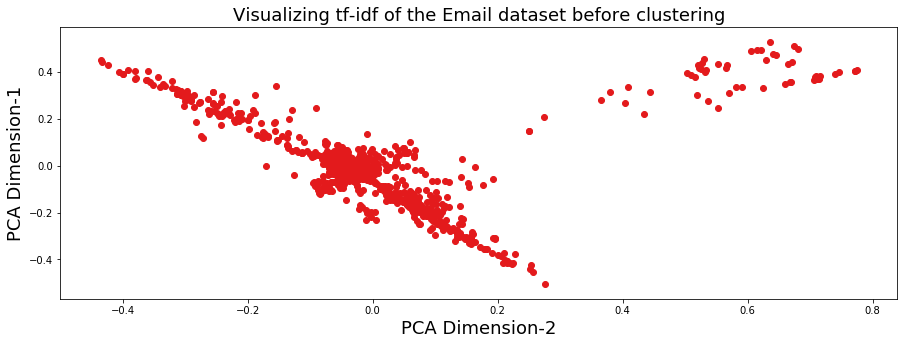

In [8]:
random.seed(3425)
#converting tf idf ndarray to matrix form 
X_matrix=X.todense()
X_matrix.shape

#Setting size for the plot figure
plt.rc('figure', figsize=(15, 5))

#converting tf idf ndarray to matrix form 
X_dense = X.todense()

coordinates = PCA(n_components=2).fit_transform(X_dense)

plt.scatter(coordinates[:, 0], coordinates[:, 1], c='#e31a1c')
plt.title("Visualizing tf-idf of the Email dataset before clustering",fontsize=18)
plt.xlabel('PCA Dimension-2', fontsize=18)
plt.ylabel('PCA Dimension-1', fontsize=18)
plt.savefig('../results_dendrograms_kmeans_visualisation/kmeansL3.jpg')

### Approaches used in determining the Right k i.e. no. of Clusters.
1. Elbow method
2. Silhouette Coefficient

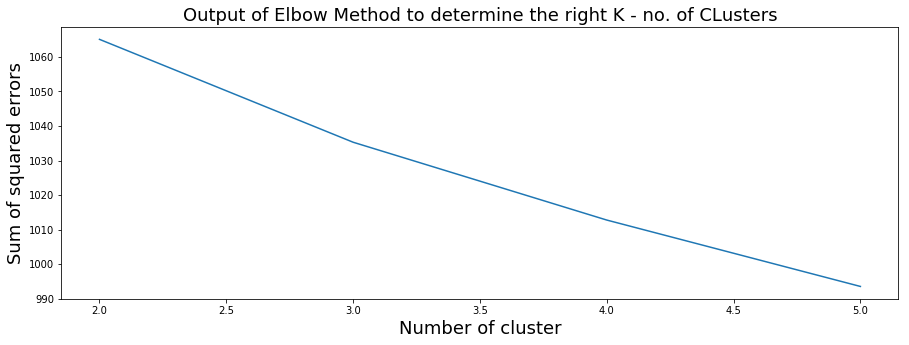

In [9]:
#Importing the required libraries

#Setting a random seed.
#this is basically because kmeans start by chosing random centroid that would give different results at each run. In order to avoid that and
#generate consistent outputs, random.seed or random_state is necessary.
random.seed(3425)

#Elbow Method
sum_squared_err = {}

#passing a range(2,6) of value for determining the optimal k 
#because (as observed in the graph below) there is no elbow formation from k=2 to k=5
for k in range(2, 6):
    
    # executing Kmeans in loop
    kmeans = KMeans(n_clusters=k, max_iter=500, random_state=3425).fit(X)
    
    #.inertia is used to find the sum of distances of samples to their closest cluster centroids i.e. sum of squared error
    sum_squared_err[k] = kmeans.inertia_ 
    
#Plotting the graph generated
plt.figure()
plt.plot(list(sum_squared_err.keys()), list(sum_squared_err.values()))
plt.title("Output of Elbow Method to determine the right K - no. of CLusters",fontsize=18)
plt.xlabel("Number of cluster", fontsize=18)
plt.ylabel("Sum of squared errors", fontsize=18)
plt.savefig('../results_dendrograms_kmeans_visualisation/elbow_kmeansL2.jpg')

In [10]:
random.seed(3425)

#Silhouette Coefficient
from sklearn.metrics import silhouette_score

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k,  max_iter=500, random_state=3425).fit(X)
    label = kmeans.labels_
    silhouette_coeff = silhouette_score(X, label, metric='euclidean')
    print(" The Silhouette Coefficient Calculated is = ",silhouette_coeff, " For K = ",k)

 The Silhouette Coefficient Calculated is =  0.018718533126990733  For K =  2
 The Silhouette Coefficient Calculated is =  0.030446833193306544  For K =  3
 The Silhouette Coefficient Calculated is =  0.038862755978172354  For K =  4
 The Silhouette Coefficient Calculated is =  0.04874077788768646  For K =  5


We proceed with k=3 as returned by the elbow method. 


### Defining K - Means Function

In [11]:
def k_means(no_of_cluster):
    n_clusters = no_of_cluster

    #Calling the function Kmeans from sklearn library    
    clf = KMeans(n_clusters=n_clusters, max_iter=500, init='k-means++', n_init=1, random_state=3425)
    

    #Storing fitted labels
    labels = clf.fit_predict(X)
    
    #Setting seed
    random.seed(3425)

    no_of_emails_in_current_cluster=[]
    for cl in range(0,n_clusters):
        no_of_emails_in_current_cluster.append(list(labels).count(cl))
    centroids = clf.cluster_centers_

    
    return centroids,labels,clf,no_of_emails_in_current_cluster

### Calling the k_means Function defined above 

In [12]:
#Calling k_means function
tuple_output=k_means(3)

#Segregating the values returned by the function and storing them in variables

#Labels
labels=tuple_output[1]

#classification model used for visualisation
clf=tuple_output[2]

#number of emails in each cluster
no_of_emails_in_cluster=tuple_output[3]

#Centroid
centroid_s=tuple_output[0]

#Transposing the Matrix for display purpose
centroids_transpose=centroid_s.transpose()

#The centroids of each cluster are a set of td-idf values of the terms.
#print(pd.DataFrame(centroids_transpose))

### Extracting Top n terms from each cluster.
here, top 5 terms from each cluster has been displayed

In [13]:
df_centroids_transpose=pd.DataFrame(centroids_transpose)
df_centroids_transpose['terms']=terms
size_df_centroids_transpose=df_centroids_transpose.shape
# type(size_df_centroids_transpose)
# len(size_df_centroids_transpose)
no_of_cols=size_df_centroids_transpose[1]
no_of_cols
for i in range(0,(no_of_cols-1)):
#     print(i)
#     print("\n")
    print("Top 5 terms in cluster number ", i)
#     print("\n")
    print(df_centroids_transpose.nlargest(5, i)['terms'])
#     print("\n")

Top 5 terms in cluster number  0
9999          mail
4233           day
3064         class
12654         post
8684     insurance
Name: terms, dtype: object
Top 5 terms in cluster number  1
15790       state
3868      country
10967      nation
638      american
12702       power
Name: terms, dtype: object
Top 5 terms in cluster number  2
14988      shop
2515     carbon
10517    mining
11080       net
15917     store
Name: terms, dtype: object


# Visualising Kmeans Cluster using PCA


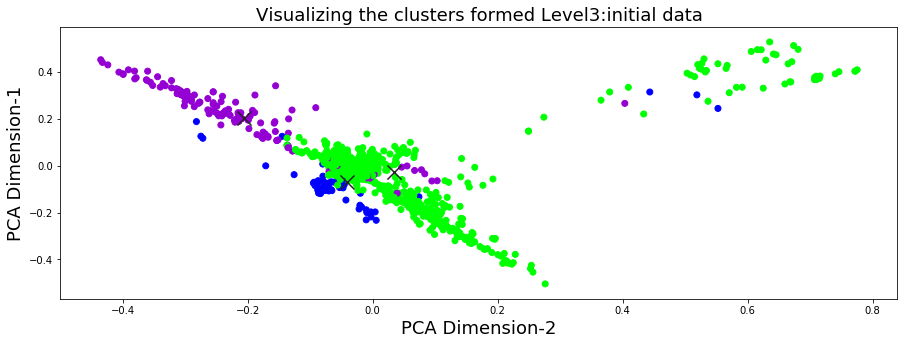

In [24]:
random.seed(1234)

pca = PCA(n_components=2).fit(X_dense)

#Defining a list of colors to be used in the visualisation. Different colour indicates different clusters
label_colors = ["#9400D3", "#0000FF", "#00FF00", "#FFFF00", "#FF7F00", "#FF0000",  "#4B0082","#FC6514"]

#Assigning distinct colors to the labels obtained
colors = [label_colors[i] for i in labels]

#Plotting the data
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=colors)

# Plot the cluster centers
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)


plt.scatter(centroid_coords[:, 0], centroid_coords[:, 1], marker='x', s=200, linewidths=1, c='#252525')
plt.title("Visualizing the clusters formed Level3:initial data", fontsize=18)
plt.xlabel('PCA Dimension-2', fontsize=18)
plt.ylabel('PCA Dimension-1', fontsize=18)

#Exporting as image
plt.savefig('../results_dendrograms_kmeans_visualisation/kmeans_cls_L3.jpg')
plt.show()

### Precision, Recall and F-Value

In [15]:
#adding the labels returned by kmeans to each of the emails in the data_subset data frame.
data_subset=data_subset.reset_index(drop=True)
data_subset['labels_kmeans']=labels
data_subset=data_subset.sort_values('labels_kmeans')

#Renaming the dataframe
kmeans_result=data_subset
kmeans_clust = kmeans_result.groupby(by='labels_kmeans')

#grouping the emails depending on their labels
df_cluster_length=kmeans_result.groupby(['labels_kmeans']).size().to_frame(name = 'No_of_Emails_each_cluster').reset_index()
print(df_cluster_length)
#Grouping by cluster labels and Extracting Cluster types
cluster_types=len(df_cluster_length['labels_kmeans'].tolist())

   labels_kmeans  No_of_Emails_each_cluster
0              0                        144
1              1                         62
2              2                        929


In [16]:
#Grouping by cluster labels
#Extracting Cluster types
cluster_types=len(df_cluster_length['labels_kmeans'].tolist())
print("Cluster types:",cluster_types)
print("Cluster lengths: ", df_cluster_length['No_of_Emails_each_cluster'].tolist())



Cluster types: 3
Cluster lengths:  [144, 62, 929]


# Extracting cluster wise data from the main dataset.

In [17]:
# Storing the Labels
kmeans_op = pd.DataFrame(labels)
# print(kmeans_op)

#Performing join on the datsets
# kmeans_result = pd.concat([kmeans_op, data_subset], axis=1, join='inner')
kmeans_result=kmeans_result.sort_values(by='labels_kmeans')

#Grouping by cluster labels
kmeans_clust = kmeans_result.groupby(kmeans_result['labels_kmeans'])


#Extracting Cluster types
cluster_types=list(set(kmeans_result['labels_kmeans']))
print("Cluster types:",cluster_types)

#Creating a list of Dataframes for each cluster
list_df_km=[]
for i in cluster_types:

#Displaying Clusterwise
    print("Cluster:", i)
    print()
    list_df_km.append(kmeans_clust.get_group(i))

Cluster types: [0, 1, 2]
Cluster: 0

Cluster: 1

Cluster: 2



## Defining a function that would calculate the Precision, Recall and the F- Value

### Precision = number of emails having the term in a cluster / number of emails in the cluster

### Recall = number of emails having the term in a cluster / total number of emails having the term

### F- Measure /F-Value = 2[(precision recall) / (precision + recall)]

In [18]:
def function_PRF(Index):
    km_data_1=list_df_km[Index].values.tolist()
    
    #Precision denominator
    P_D=no_of_emails_in_cluster[Index]
    
    pre_pros_emails=[]
    k_updated=[]
    for k in km_data_1:
        remo_digit=[]
        for item in k:
            if type(item) == int:
                item=None
                remo_digit.append(item)
            else:
                remo_digit.append(item)

        #Filtering out None
        str_list = list(filter(None, remo_digit))

        #Removing Punctuation
        no_punct=[no_punctuation(str(i)) for i in str_list]

        #Tokenizing the strings
        split_str=list(chain(*[i.split() for i in no_punct]))

        #Word Segmentation
        seg_split_str=list(chain(*[segment(j) for j in split_str]))
    
        no_stop_word=stopword_remove(seg_split_str)

        #Removing words with length less than  or equal to 3
        clean_str=[(re.sub(r'\b\w{1,3}\b', '', c)) for c in no_stop_word]

        #Stripping Whitespace if any
        km_to_empty = [x.strip() for x in clean_str]
        km_clean_list = list([x for x in km_to_empty if x])

        #Storing
        k_updated.append(km_clean_list)

        #Calculating Frequency of Terms
        Term_freq_each_email = Counter(km_clean_list).most_common()



    #Calculating term freq in current cluster
    Term_freq=Counter(list(chain(*k_updated))).most_common()

    #Converting segmented emails into strings
    k_updated_emails=[' '.join(ka) for ka in k_updated]
    pre_pros_emails.append(k_updated_emails)


    #Extracting Terms from tuple
    terms_=[t[0] for t in Term_freq]

    ##################Calculating Precision and Recall##########################################
    numerator_P_R=[]
    recall_den=[]
    for t_ in terms_:
        count_email_with_a_term=0
        count_email_with_a_term_in_all_cluster=0

        #Number of Emails with term t in the current cluster
        for i in k_updated_emails:
            if t_ in i:
                count_email_with_a_term=count_email_with_a_term+1
        numerator_P_R.append(count_email_with_a_term)

        #Number of Emails with term t overall
        for f in flat_list2_syn:
            if t_ in f:
                count_email_with_a_term_in_all_cluster=count_email_with_a_term_in_all_cluster+1
        recall_den.append(count_email_with_a_term_in_all_cluster)

    
    recall=[(p*1.0)/(r or not r) for p,r in zip(numerator_P_R, recall_den)]

    
    P_num=np.array(numerator_P_R, dtype=np.float)
    P_den=np.array(P_D, dtype=np.float)

    precision_denominator=sum(P_num[0:len(P_num)])
    precision=list(np.nan_to_num(np.divide(P_num, precision_denominator)))

    ########################### F - Score ####################################

    #Calculating F-Score using formula (F=2*(P*R)/(P+R))    
    f_step1=[i*j for i,j in zip(precision,recall)]
    f_step2=[num*2 for num in f_step1]
    f_step3=list( map(add, precision, recall) )
    f_value=[(x*1.0)/y for x, y in zip(f_step2, f_step3)]
    
    #Dataframe with all values
    #Returning only the first five rows from the datadet conatining F-value, Precision and Recall
    P_R_F =pd.DataFrame({'Term': terms_, 'Precision': precision, 'Recall':recall, 'F-Value':f_value})
    return P_R_F.iloc[0:5,:],pre_pros_emails

### Calling the Precision and Recall Function defined above to display the F value

In [19]:
processed_cluster_data=[]
for ind in range(0,len(no_of_emails_in_cluster)):
    print("Cluster: ", ind)
    processed_cluster_data.append(function_PRF(ind)[1])
    print(function_PRF(ind)[0].sort_values('F-Value',  ascending=False))

Cluster:  0
    F-Value  Precision    Recall       Term
0  0.116796   0.070000  0.352349       mail
2  0.037644   0.020667  0.210884     august
3  0.035757   0.020000  0.168539   thursday
4  0.033195   0.018667  0.149733  wednesday
1  0.027097   0.014000  0.420000  insurance
Cluster:  1
    F-Value  Precision    Recall     Term
1  0.157216   0.086402  0.871429   states
0  0.156010   0.086402  0.802632   united
4  0.029954   0.018414  0.080247   monday
2  0.026943   0.018414  0.050193   mining
3  0.018111   0.009915  0.104478  hotmail
Cluster:  2
    F-Value  Precision    Recall       Term
0  0.041835   0.021415  0.899614     mining
1  0.028011   0.014246  0.828877  wednesday
2  0.026976   0.013695  0.892216     viagra
3  0.026587   0.013511  0.825843     friday
4  0.025864   0.013143  0.803371   thursday


### Data Preparation for LDA

In [20]:
random.seed(3425)
stop = set(stopwords.words('english'))
stop_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours","hibody", "yourself", "spam","body","yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
      
punct_1 = set(string.punctuation) 
lemma = WordNetLemmatizer()

def clean(doc):
    #Removing Stop words
    stop_removed = " ".join([i for i in doc.lower().split() if i not in stop_words])
    
    #removing Punctation
    punc_free = ''.join(i for i in stop_removed if i not in punct_1)
    
    #for stemming 
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    result = ''.join([i for i in normalized if not i.isdigit()])    
    return result

In [21]:
random.seed(3425)
#list conatining pre-processed data
pre_pros_list1=[]

#Flattening and storing it
for p in processed_cluster_data:
    pre_pros_list1.append(list(chain(*p)))

#Creation of dictionary note: pre_pros_list are the clusters obtained from the kmeans functions.
doc_clean = [clean(doc).split() for doc in  list(chain(*pre_pros_list1))] 
dictionary = gensim.corpora.Dictionary(doc_clean)

    # dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in doc_clean]
#
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=len(processed_cluster_data), id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(-1):
    print('\n Topic: {} \nWords: {}'.format(idx, topic))


 Topic: 0 
Words: 0.045*"mining" + 0.023*"thursday" + 0.017*"mail" + 0.016*"wednesday" + 0.015*"viagra" + 0.014*"september" + 0.011*"monday" + 0.011*"sunday" + 0.010*"saturday" + 0.008*"june"

 Topic: 1 
Words: 0.038*"mining" + 0.020*"friday" + 0.019*"hotmail" + 0.013*"monday" + 0.013*"saturday" + 0.012*"july" + 0.012*"viagra" + 0.011*"pfizer" + 0.009*"august" + 0.009*"sunday"

 Topic: 2 
Words: 0.023*"tuesday" + 0.022*"mining" + 0.019*"mail" + 0.016*"august" + 0.014*"wednesday" + 0.013*"july" + 0.012*"april" + 0.011*"friday" + 0.010*"yahoo" + 0.009*"monday"


# Computing Perplexity and Coherence to evaluate topic models formed

In [22]:

# Compute Perplexity : lowest perplexity is considered the best.
perplexity=lda_model.log_perplexity(bow_corpus)
print('\n Perplexity of the Spam Classification model: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Coherence Score of the Spam Classification model: ', coherence_lda)


 Perplexity of the Spam Classification model:  -7.282961643860075

 Coherence Score of the Spam Classification model:  0.31306160035031483


In [23]:
pyLDAvis.enable_notebook()
id2word=dictionary
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      34.786678        1       1  0.072864  0.046177
0      33.408119        1       2  0.006373 -0.082042
2      31.805206        1       3 -0.079237  0.035865, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
191   Default   98.000000       hotmail   98.000000  30.0000  30.0000
7     Default  141.000000          mail  141.000000  29.0000  29.0000
30    Default  125.000000       tuesday  125.000000  28.0000  28.0000
14    Default  138.000000      thursday  138.000000  27.0000  27.0000
3     Default  140.000000        friday  140.000000  26.0000  26.0000
81    Default   29.000000         email   29.000000  25.0000  25.0000
44    Default   19.000000       message   19.000000  24.0000  24.0000
43    Default   22.000000      facebook   22.000000  23.0000  23.0000
108   Default  396.000000        mining  396.000000  22.0000  22.0000
46    Default   15.000000          sent   15.000000  21.0000  21.0000
627   Default   32.000000         store   32.000000  20.0000  20.0000
45    Default   16.000000  notification   16.000000  19.0000  19.0000
50    Default   80.000000         april   80.000000  18.0000  18.0000
205   Default   30.000000       january   30.000000  17.0000  17.0000
0     Default  115.000000        august  115.000000  16.0000  16.0000
9     Default   45.000000     insurance   45.000000  15.0000  15.0000
672   Default   30.000000      discount   30.000000  14.0000  14.0000
541   Default   72.000000        pfizer   72.000000  13.0000  13.0000
187   Default    8.000000       harvest    8.000000  12.0000  12.0000
4     Default   16.000000          ilug   16.000000  11.0000  11.0000
107   Default   34.000000      february   34.000000  10.0000  10.0000
126   Default   56.000000       october   56.000000   9.0000   9.0000
6     Default   15.000000         linux   15.000000   8.0000   8.0000
96    Default   39.000000         offer   39.000000   7.0000   7.0000
649   Default   31.000000          user   31.000000   6.0000   6.0000
596   Default   13.000000          site   13.000000   5.0000   5.0000
79    Default  106.000000      saturday  106.000000   4.0000   4.0000
238   Default   27.000000          life   27.000000   3.0000   3.0000
132   Default   12.000000        eudora   12.000000   2.0000   2.0000
365   Default   16.000000          news   16.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
188    Topic3    5.230101           lot    6.948040   0.8615  -6.5282
9      Topic3   27.400106     insurance   45.623116   0.6357  -4.8720
828    Topic3    4.186755        inkjet    5.406838   0.8898  -6.7507
238    Topic3   17.256693          life   27.852505   0.6668  -5.3344
50     Topic3   42.429485         april   80.102859   0.5101  -4.4347
0      Topic3   56.551105        august  115.005615   0.4357  -4.1474
7      Topic3   66.759621          mail  141.622467   0.3935  -3.9815
49     Topic3   34.497559         yahoo   75.065689   0.3681  -4.6417
61     Topic3    6.166067         flash    8.478749   0.8270  -6.3635
23     Topic3   45.135345          july  122.227669   0.1493  -4.3729
42     Topic3   49.723206     wednesday  145.436768   0.0723  -4.2761
288    Topic3    9.712867          home   16.304949   0.6275  -5.9091
177    Topic3   20.244734         watch   45.566055   0.3343  -5.1747
1      Topic3    9.865996      business   17.026432   0.5999  -5.8935
3      Topic3   40.049110        friday  140.170380  -0.1072  -4.4925
108    Topic3   78.575272        mining  396.018677  -0.4719  -3.8185
365    Topic3    9.419065          news   16.394932   0.5913  -5.9398
47     Topic3   32.181767        sunday  107.872101  -0.0640  -4.7112
182    Topic3   23.701233          june   73.505905   0.0137  -5.0171
54     Topic3   32.374565        monday  125.32